# Лабораторная работа #1: Рекуррентные нейронные сети

## Задача 1: PoS-tagging

В данной лабораторной работе будут использоваться корпуса проекта Universal Dependencies: http://universaldependencies.org/

Непосредственно корпуса можно скачать по адресу: https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-2515

### Часть I Работа с корпусом CoNLL
В этой части предусматривается работа с корпусом CoNLL - предварительная обработка, чтение и парсинг корпуса, а также определение размера словаря.
Считайте из файла данные и получите статистику:
* Размер самого длинного предложения;
* Количество предложений в корпусе;
* Уникальное число слов в словаре;
* Уникальное число меток;

Для **удобной** работы с CoNLL разметкой предлагается использовать библиотеку: https://github.com/EmilStenstrom/conllu

Но это отнюдь не означает, что вы не можете написать ваш собственный парсер.

In [14]:
from conllu.parser import parse, parse_tree
from collections import Counter
import numpy as np


import matplotlib.pyplot as plt
from keras.layers.core import Activation, Dense, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.metrics import top_k_categorical_accuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import np_utils

Урду́ — индоевропейский язык, функциональный стиль языка хиндустани, на разговорном уровне взаимопонятный с хинди, возникший в XIII веке. 
Урду является одним из двух официальных языков в Пакистанею
В Индии урду является одним из 22 официальных языков. Здесь на нём говорят около 50 миллионов человек
Относится к: Индоарийская группа - Индоиранская ветвь - Индоевропейская семья

Задаем имена файлов с тренировочным и тестовым наборами:

In [15]:
# -*- coding: utf-8 -*- 
data = 'europarl-v7.de-en.de'
data1 = 'europarl-v7.de-en.en'
import codecs
fileObj = codecs.open( data, "r", "utf_8_sig" )
text = fileObj.readlines() # или читайте по строке
fileObj.close()
fileObj1 = codecs.open( data1, "r", "utf_8_sig" )
text1 = fileObj1.readlines() # или читайте по строке
fileObj1.close()     

Функция 
    parsed_sentences
читает conll файл, и проводит его обработку, подсчитывая:
* sents_word - список списков словоформ (внешний список - предложения, внутренний список - слова в этом предложении);
* word_frequencies - коллекция типа Counter для подсчета частоты словоформ
* sents_pos - список списов PoS тегов (соответствующих словам из sents_word);
* pos_frequencies - коллекция типа Counter для подсчета частоты PoS-тегов.

In [16]:
from keras.preprocessing.text import text_to_word_sequence
sentence_de=[]
for i in text[:10000]:
    sentence_de.append(text_to_word_sequence(i, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" "))
sentence_en=[]
for i in text1[:10000]:
    sentence_en.append(text_to_word_sequence(i, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" "))

print(sentence_de[:10])
print(sentence_en[:10])

[['wiederaufnahme', 'der', 'sitzungsperiode'], ['ich', 'erkläre', 'die', 'am', 'freitag', 'dem', '17', 'dezember', 'unterbrochene', 'sitzungsperiode', 'des', 'europäischen', 'parlaments', 'für', 'wiederaufgenommen', 'wünsche', 'ihnen', 'nochmals', 'alles', 'gute', 'zum', 'jahreswechsel', 'und', 'hoffe', 'daß', 'sie', 'schöne', 'ferien', 'hatten'], ['wie', 'sie', 'feststellen', 'konnten', 'ist', 'der', 'gefürchtete', 'millenium', 'bug', 'nicht', 'eingetreten', 'doch', 'sind', 'bürger', 'einiger', 'unserer', 'mitgliedstaaten', 'opfer', 'von', 'schrecklichen', 'naturkatastrophen', 'geworden'], ['im', 'parlament', 'besteht', 'der', 'wunsch', 'nach', 'einer', 'aussprache', 'im', 'verlauf', 'dieser', 'sitzungsperiode', 'in', 'den', 'nächsten', 'tagen'], ['heute', 'möchte', 'ich', 'sie', 'bitten', 'das', 'ist', 'auch', 'der', 'wunsch', 'einiger', 'kolleginnen', 'und', 'kollegen', 'allen', 'opfern', 'der', 'stürme', 'insbesondere', 'in', 'den', 'verschiedenen', 'ländern', 'der', 'europäischen'

Считываем файлы тренировочной и тестовой выборки, и формируем (для каждого свою) наборы 
* sents_word
* word_frequencies
* sents_pos
* pos_frequencies

In [13]:
word_frec_de={}
for i in sentence_de:
    for j in i:
        if j not in word_frec_de:
            word_frec_de[j]=1
        else:
            word_frec_de[j]+=1

word_frec_en={}            
for i in sentence_en:
    for j in i:
        if j not in word_frec_en:
            word_frec_en[j]=1
        else:
            word_frec_en[j]+=1
print(word_frec_de['die'])

10248


In [30]:
k=len(sentence_en)-1000
sents_word=sentence_en[:k]
word_frequencies=word_frec_en

        
sents_pos=sentence_de[:k]
pos_frequencies=word_frec_de

test_sents_word=sents_word[k:]
test_word_frequencies= word_frec_en
test_sents_pos=sents_pos[:150:-1]
test_pos_frequencies=word_frec_de


In [31]:
for i in sents_word:
    word_frequencies_sen=[]
    for j in i:
        word_frequencies_sen.append(word_frec_en[j])
    word_frequencies.append(word_frequencies_sen)

for i in sents_pos:
    pos_frequencies=[]
    for j in i:
        word_frequencies_sen.append(word_frec_de[j])
    pos_frequencies.append(word_frequencies_sen)

AttributeError: 'dict' object has no attribute 'append'

Выведете статистику, для тренировочной и тестовой выборки
Статистика должна отражать:
* Число предложений;
* Число словоформ;
* Число уникальных PoS тегов;
* Максимальное число слов в предложении;
* Минимальное число слов в предложении;
* Среднее арифметическое и среднее медианное число слов в предложении;
* Доля пересечения словоформ в тестовой и тренировочной выборке;

In [32]:
train_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in sents_word])
test_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in test_sents_word])
test_length_of_sentences_list[:100]

array([ 7, 23, 21,  6, 37, 42, 30, 18, 19, 14, 19, 22, 15, 11, 43, 23, 26,
       61, 19, 32, 37, 23, 22, 16,  7, 29, 17, 21, 31, 50, 23, 25, 34, 40,
       15, 25, 18, 20, 49, 28, 19, 39, 33, 60,  9, 22, 24, 24,  6, 40, 25,
       29, 42, 17, 11, 30,  2, 21, 12, 25, 21, 27,  9, 21, 30, 22, 28, 20,
        5, 43, 37, 38, 33, 17, 23, 18, 19, 19, 53, 62, 19, 48, 30, 17, 14,
       26, 22, 22, 29,  0, 12, 18, 37, 15, 14, 11, 25, 43, 13,  6])

In [33]:
train_words=[]
test_words=[]
for i in word_frequencies.keys():
    train_words.append(i)
for i in test_word_frequencies.keys():
    test_words.append(i)
intersection=len(np.intersect1d(np.array(train_words),np.array(test_words)))

In [34]:
print("Stats: ")



print("Train set: \n\tCount sentences: {} \n\tUnique words: {}".format(len(sents_word), len(word_frequencies)))
print("\tUnique PoS tags: {}".format(len(pos_frequencies)))
print("\tMax count words in sentences: {}".format(np.max(np.array(train_length_of_sentences_list))))
print("\tMin count words in sentence: {}".format(np.min(np.array(train_length_of_sentences_list))))
print("\tMean count words in sentence: {}".format(np.mean(np.array(train_length_of_sentences_list))))
print("\tMean of median count words in sentence: {}".format(np.mean(np.median((train_length_of_sentences_list)))))
print("\tIntersection: {}".format(intersection))

print("Tr set: \n\tCount sentences: {} \n\tUnique words: {}".format(len(sents_word), len(word_frequencies)))
print("\tUnique PoS tags: {}".format(len(pos_frequencies)))
print("\tMax count words in sentences: {}".format(np.max(np.array(train_length_of_sentences_list))))
print("\tMin count words in sentence: {}".format(np.min(np.array(train_length_of_sentences_list))))
print("\tMean count words in sentence: {}".format(np.mean(np.array(train_length_of_sentences_list))))
print("\tMean of median count words in sentence: {}".format(np.mean(np.median((train_length_of_sentences_list)))))
print("\tIntersection: {}".format(intersection))

Stats: 
Train set: 
	Count sentences: 9850 
	Unique words: 10976
	Unique PoS tags: 19209
	Max count words in sentences: 161
	Min count words in sentence: 0
	Mean count words in sentence: 25.72213197969543
	Mean of median count words in sentence: 22.0
	Intersection: 10976
Tr set: 
	Count sentences: 9850 
	Unique words: 10976
	Unique PoS tags: 19209
	Max count words in sentences: 161
	Min count words in sentence: 0
	Mean count words in sentence: 25.72213197969543
	Mean of median count words in sentence: 22.0
	Intersection: 10976


На основании полученных Вами данных примите решения, касающиеся ключевых параметров нейронной сети:
* Максимальная длина последовательности (MAX_SEQLEN);
* Максимальное количество атрибутов (S_MAX_FEATURES);
* Максимальное количество тегов (T_MAX_FEATURES);

**Замечание**: *MAX_SEQLEN* не обязательно должна равна максимальному числу слов в предложении, особенно если встречается всего 1 такое предложение.

In [35]:
MAX_SEQLEN = np.max(np.array(train_length_of_sentences_list[0]))                
S_MAX_FEATURES =len(word_frequencies)
T_MAX_FEATURES = len(pos_frequencies)
S_MAX_FEATURES

10976

Объясните свой выбор целевых параметров:
* MAX_SEQLEN  
* S_MAX_FEATURES 
* T_MAX_FEATURES 

Параметры по умолчанию для числа нейронов в скрытом слое, объема пространства погружения и размера пакета.

Можно использовать стандартные, можно поиграться с ними.

In [36]:
EMBED_SIZE = 300
HIDDEN_SIZE = 100

BATCH_SIZE = 64

Задайте число эпох и итераций:

In [37]:
NUM_EPOCHS = 20 
NUM_ITERATIONS = 3

Как и в большинстве других задач глубокого обучения, каждая строчка должна быть закодирована индексами слов. Кроме того, выход (PoS-теги) должны быть последовательностями индексов PoS-тегов.
Поэтомк, мы создаем табличцы для перевода слов/PoS-тегов в соответствующие индексы.
Словарь словоформ должен иметь 2 дополнительных метки:
* PAD - для заполнения (характеризует пустоту), когда размер предложения меньше, чем MAX_SEQLEN
* UNK - для неизвестных словоформ.

Кроме того, захотим проиллюстрировать PoS-теггер, поэтому нужно составить таблицы для поиска словоформ и частеречевых тегов.
Ниже показано задание таблиц.

Составляем таблицу поиска для словоформ:

In [38]:
s_vocabsize = min(len(word_frequencies), S_MAX_FEATURES) + 2
s_word2index = {x[0]:i+2 for i, x in 
    enumerate(word_frequencies)}
s_word2index["PAD"] = 0 # Для заполнения, когда размер предлложения меньше, чем MAX_SEQ
s_word2index["UNK"] = 1 # Для неизвестных словоформ, которые могут встретиться
s_index2word = {v:k for k, v in s_word2index.items()}

Таблицу поиска частеречевых меток предлагается создать самостоятельно:

**Замечание: ** для PoS-тегов элемент UNK не нужен, поскольку список частей речи уже известен. Элемент PAD нужен.

In [39]:
t_vocabsize = min(len(pos_frequencies), T_MAX_FEATURES) + 1
t_word2index = {x[0]:i+1 for i, x in 
    enumerate(pos_frequencies)}

t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

Составляем целевую нейронную сеть, которая и будет выполнять частеречную разметку.

Коротко об архитектуре нейронной сети:
Как и в других задачах, считаем, что входом в нейросеть является трехмерный тензор, элементами которого являются индексы слов, длины MAX_SEQLEN;

Это проходит через слой погружения (Embedding), которому явно указывается размер словаря и размерность погружения, поэтому результат прохождения входного тензора через слой погружения будет тензор сл. формата:
(None, MAX_SEQLEN, EMBED_SIZE);

Далее этот тензор передается encoder'у - представляющий собой слой рекуррентной нейронной сети с размером выхода HIDDEN_SIZE. LSTM настроен на возврат единственного контекстного вектора (return_sequences=False - по умолчанию) после обработки последовательности длины MAX_SEQLEN, поэтому тензор LSTM слоя имеет форму (None, HIDDEN_SIZE).

Этот контекстный вектор далее реплицируется слоем 
    RepeatVector
в тензор формы (None, MAX_SEQLEN, t_vocab_size). В качестве функции активации в плотном слое используется softmax.

**Задание: **
* Построить четыре модели нейронной сети:
    * SimpleRNN
    * LSTM
    * Bidirectional
    * GRU

In [40]:
def build_pos_tagger_LSTM():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(LSTM(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

Объясните необходимость использования в качестве функции потерь категориальную энтропию
**Ответ**: Кросс энтропия всегда используется при многоклассовой классификации. Задачи на пост-теггинг также можно отнести к частному случаю подобных классификаций,строится модель seq2seq, где каждое слово должно быть отнесену к одному из имеющихся частеречных классов

Выведите архитектуру сети посредством метода summary() модели Keras.

In [41]:
LSTM_POS_TAGGER = build_pos_tagger_LSTM()
LSTM_POS_TAGGER.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 300)            3293400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 100)            80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 19210)          1940210   
_________________________________________________________________
activation_1 (Activation)    (None, 4, 19210)          0         
Total params: 5,474,410
Trainable params: 5,474,410
Non-trainable params: 0
_________________________________________________________________


Подсчитаем объем количества батчей для тренировочной и тестовой выборки, кроме того, сделаем функцию для получения генератора батчей.

In [42]:
num_train_samples = len(sents_word) // BATCH_SIZE
num_test_samples = len(test_sents_word) // BATCH_SIZE

print("\tV of train samples: {}".format(num_train_samples))
print("\tV of test samples: {}".format(num_test_samples))

def get_or_else(dictionary, key, default_value):
    try:
        return dictionary[key]
    except KeyError:
        return default_value

def generate_batch(
    s_sents,  # sentences_train
    s_word2index, # word to index dictionary
    t_sents, # 
    t_word2index, 
    batch_size, 
    maxlen
):
    while True:
        # shuffle the input
        indices = np.random.permutation(np.arange(len(s_sents)))
        ss_sents = [s_sents[ix] for ix in indices]
        ts_sents = [t_sents[ix] for ix in indices]
        # convert to word indices
        si_sents = [[get_or_else(s_word2index, word, s_word2index["UNK"]) 
                    for word in sent] 
                    for sent in ss_sents]
        ti_sents = [[t_word2index[word] for word in sent]
                    for sent in ts_sents]
        # inner loop should run for an epoch
        num_batches = len(s_sents) // batch_size
        for i in range(num_batches):
            s_batch = si_sents[i * batch_size : (i + 1) * batch_size]
            t_batch = ti_sents[i * batch_size : (i + 1) * batch_size]
            sp_batch = sequence.pad_sequences(s_batch, maxlen=maxlen)
            tp_batch = sequence.pad_sequences(t_batch, maxlen=maxlen)
            tpc_batch = np_utils.to_categorical(tp_batch.reshape(-1, 1), 
                num_classes=len(t_word2index)).reshape(batch_size, 
                -1, len(t_word2index))
            yield sp_batch, tpc_batch

	V of train samples: 153
	V of test samples: 151


Инициализируем генераторы для тренировочной и тестовой выборки. 

In [43]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

Обновляем списки с историями для точности, функции потерь на тренировочной и тестовой выборках:

In [44]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []


In [46]:
for i in range(NUM_ITERATIONS):    
    history = LSTM_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = LSTM_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    '''for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)'''

Epoch 1/20


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
StopIteration



StopIteration: 

Постройте и выведите графики функции потерь и точности на тренировочной и тестовой выборке.
Можете воспользоваться заготовкой ниже - заполнив недостающие элементы (с примером), или написать свою

In [124]:
#hist_acc, [range(len(hist_acc))]

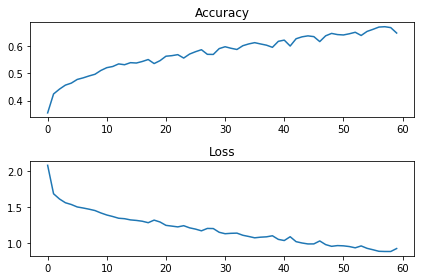

In [125]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot( [i for i in range(len(hist_acc))],hist_acc)

plt.subplot(212)
plt.title("Loss")
plt.plot( [i for i in range(len(hist_loss))],hist_loss)
plt.tight_layout()
plt.show()

##Simple RNN

In [15]:
from keras.layers.recurrent import SimpleRNN
def build_pos_tagger_Simple():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(SimpleRNN(HIDDEN_SIZE, unroll=True))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

SIMPLE_POS_TAGGER = build_pos_tagger_Simple()
SIMPLE_POS_TAGGER.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 300)           2864700   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 31, 100)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 31, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 31, 17)            1717      
_________________________________________________________________
activation_1 (Activation)    (None, 31, 17)            0         
Total params: 2,926,617
Trainable params: 2,926,617
Non-trainable params: 0
_________________________________________________________________


In [20]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

hist_acc_simple, hist_val_acc_simple, hist_loss_simple, hist_val_loss_simple = [], [], [], []

for i in range(NUM_ITERATIONS):    
    history = SIMPLE_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc_simple.extend(history.history["acc"])
    hist_val_acc_simple.extend(history.history["val_acc"])
    hist_loss_simple.extend(history.history["loss"])
    hist_val_loss_simple.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = SIMPLE_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/20
63/63 [==============================] - 18s - loss: 1.9583 - acc: 0.3759 - val_loss: 1.7747 - val_acc: 0.4086
Epoch 2/20
63/63 [==============================] - 12s - loss: 1.7076 - acc: 0.4250 - val_loss: 1.6368 - val_acc: 0.4219
Epoch 3/20
63/63 [==============================] - 12s - loss: 1.5991 - acc: 0.4517 - val_loss: 1.5929 - val_acc: 0.4462
Epoch 4/20
63/63 [==============================] - 12s - loss: 1.5667 - acc: 0.4657 - val_loss: 1.5496 - val_acc: 0.4639
Epoch 5/20
63/63 [==============================] - 12s - loss: 1.5172 - acc: 0.4838 - val_loss: 1.5560 - val_acc: 0.4495
Epoch 6/20
63/63 [==============================] - 12s - loss: 1.4847 - acc: 0.4931 - val_loss: 1.5554 - val_acc: 0.4510
Epoch 7/20
63/63 [==============================] - 12s - loss: 1.4487 - acc: 0.5035 - val_loss: 1.4730 - val_acc: 0.4885
Epoch 8/20
63/63 [==============================] - 12s - loss: 1.4121 - acc: 0.5140 - val_loss: 1.5125 - val_acc: 0.4527
Epoch 9/20
63/63 [======

63/63 [==============================] - 12s - loss: 0.9085 - acc: 0.6528 - val_loss: 1.8005 - val_acc: 0.4612
Epoch 2/20
63/63 [==============================] - 13s - loss: 0.9222 - acc: 0.6449 - val_loss: 1.7949 - val_acc: 0.4572
Epoch 3/20
63/63 [==============================] - 13s - loss: 0.9187 - acc: 0.6447 - val_loss: 1.7279 - val_acc: 0.4791
Epoch 4/20
63/63 [==============================] - 14s - loss: 0.8872 - acc: 0.6600 - val_loss: 1.7437 - val_acc: 0.4748
Epoch 5/20
63/63 [==============================] - 13s - loss: 0.8708 - acc: 0.6623 - val_loss: 1.8089 - val_acc: 0.4615
Epoch 6/20
63/63 [==============================] - 13s - loss: 0.8667 - acc: 0.6652 - val_loss: 1.8004 - val_acc: 0.4716
Epoch 7/20
63/63 [==============================] - 12s - loss: 0.8609 - acc: 0.6661 - val_loss: 1.8162 - val_acc: 0.4707
Epoch 8/20
63/63 [==============================] - 12s - loss: 0.8465 - acc: 0.6722 - val_loss: 1.8115 - val_acc: 0.4730
Epoch 9/20
63/63 [=================

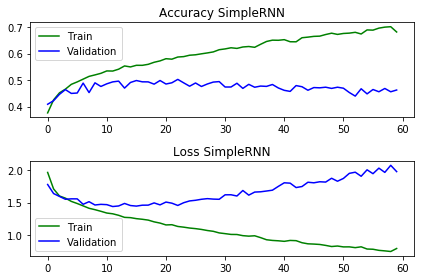

In [21]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy SimpleRNN")
plt.plot(hist_acc_simple, color="g", label="Train")
plt.plot(hist_val_acc_simple, color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss SimpleRNN")
plt.plot(hist_loss_simple, color="g", label="Train")
plt.plot(hist_val_loss_simple, color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [22]:
def build_pos_tagger_GRU():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(GRU(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(GRU(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

GRU_POS_TAGGER = build_pos_tagger_GRU()
GRU_POS_TAGGER.summary()

train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 31, 300)           2864700   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               120300    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 31, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 31, 100)           60300     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 31, 17)            1717      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 17)            0         
Total params: 3,047,017
Trainable params: 3,047,017
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist_acc_gru, hist_val_acc_gru, hist_loss_gru, hist_val_loss_gru = [], [], [], []

for i in range(NUM_ITERATIONS):    
    history = GRU_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc_gru.extend(history.history["acc"])
    hist_val_acc_gru.extend(history.history["val_acc"])
    hist_loss_gru.extend(history.history["loss"])
    hist_val_loss_gru.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = GRU_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/20
63/63 [==============================] - 37s - loss: 2.2236 - acc: 0.3053 - val_loss: 1.7936 - val_acc: 0.4157
Epoch 2/20
63/63 [==============================] - 26s - loss: 1.7338 - acc: 0.4133 - val_loss: 1.6728 - val_acc: 0.4223
Epoch 3/20
63/63 [==============================] - 26s - loss: 1.6802 - acc: 0.4204 - val_loss: 1.6530 - val_acc: 0.4237
Epoch 4/20
63/63 [==============================] - 26s - loss: 1.6109 - acc: 0.4413 - val_loss: 1.5953 - val_acc: 0.4316
Epoch 5/20
63/63 [==============================] - 26s - loss: 1.5728 - acc: 0.4525 - val_loss: 1.5653 - val_acc: 0.4579
Epoch 6/20
63/63 [==============================] - 26s - loss: 1.5479 - acc: 0.4604 - val_loss: 1.5497 - val_acc: 0.4515
Epoch 7/20
63/63 [==============================] - 26s - loss: 1.5209 - acc: 0.4714 - val_loss: 1.4738 - val_acc: 0.4897
Epoch 8/20
63/63 [==============================] - 26s - loss: 1.4980 - acc: 0.4801 - val_loss: 1.4828 - val_acc: 0.4642
Epoch 9/20
63/63 [======

63/63 [==============================] - 26s - loss: 1.1742 - acc: 0.5845 - val_loss: 1.3653 - val_acc: 0.5243
Epoch 2/20
63/63 [==============================] - 25s - loss: 1.1622 - acc: 0.5876 - val_loss: 1.3410 - val_acc: 0.5294
Epoch 3/20
63/63 [==============================] - 25s - loss: 1.1497 - acc: 0.5918 - val_loss: 1.3655 - val_acc: 0.5257
Epoch 4/20
63/63 [==============================] - 26s - loss: 1.1532 - acc: 0.5891 - val_loss: 1.3809 - val_acc: 0.5251
Epoch 5/20
63/63 [==============================] - 25s - loss: 1.1590 - acc: 0.5862 - val_loss: 1.4297 - val_acc: 0.5026
Epoch 6/20
63/63 [==============================] - 25s - loss: 1.1692 - acc: 0.5803 - val_loss: 1.3733 - val_acc: 0.5263
Epoch 7/20
63/63 [==============================] - 26s - loss: 1.1515 - acc: 0.5875 - val_loss: 1.3695 - val_acc: 0.5253
Epoch 8/20
63/63 [==============================] - 26s - loss: 1.1306 - acc: 0.5944 - val_loss: 1.3860 - val_acc: 0.5192
Epoch 9/20
63/63 [=================

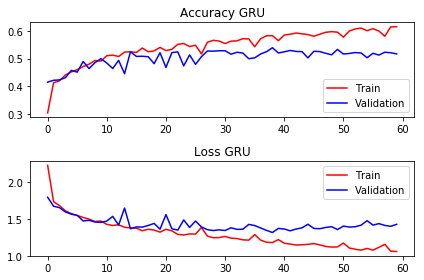

In [24]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy GRU")
plt.plot(hist_acc_gru, color="r", label="Train")
plt.plot(hist_val_acc_gru, color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss GRU")
plt.plot(hist_loss_gru, color="r", label="Train")
plt.plot(hist_val_loss_gru, color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## BIDIRECTIONAL

In [25]:
from keras.layers.wrappers import TimeDistributed, Bidirectional
def build_pos_tagger_Bidirectional():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(Bidirectional(LSTM(HIDDEN_SIZE, dropout_W=0.2, dropout_U=0.2)))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

BI_POS_TAGGER = build_pos_tagger_Bidirectional()
BI_POS_TAGGER.summary()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 31, 300)           2864700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 31, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 31, 200)           240800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 31, 17)            3417      
_________________________________________________________________
activation_3 (Activation)    (None, 31, 17)            0         
Total params: 3,429,717
Trainable params: 3,429,717
Non-trainable params: 0
_________________________________________________________________


In [26]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

hist_acc_bi, hist_val_acc_bi, hist_loss_bi, hist_val_loss_bi = [], [], [], []

for i in range(NUM_ITERATIONS):    
    history = BI_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc_bi.extend(history.history["acc"])
    hist_val_acc_bi.extend(history.history["val_acc"])
    hist_loss_bi.extend(history.history["loss"])
    hist_val_loss_bi.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = BI_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/20
63/63 [==============================] - 80s - loss: 1.9077 - acc: 0.3915 - val_loss: 1.6238 - val_acc: 0.4619
Epoch 2/20
63/63 [==============================] - 60s - loss: 1.5787 - acc: 0.4667 - val_loss: 1.5361 - val_acc: 0.4689
Epoch 3/20
63/63 [==============================] - 60s - loss: 1.4906 - acc: 0.4870 - val_loss: 1.4653 - val_acc: 0.4865
Epoch 4/20
63/63 [==============================] - 62s - loss: 1.4364 - acc: 0.5026 - val_loss: 1.4053 - val_acc: 0.4976
Epoch 5/20
63/63 [==============================] - 60s - loss: 1.3902 - acc: 0.5195 - val_loss: 1.3714 - val_acc: 0.5233
Epoch 6/20
63/63 [==============================] - 62s - loss: 1.3539 - acc: 0.5334 - val_loss: 1.3288 - val_acc: 0.5279
Epoch 7/20
63/63 [==============================] - 62s - loss: 1.3295 - acc: 0.5395 - val_loss: 1.3221 - val_acc: 0.5358
Epoch 8/20
63/63 [==============================] - 61s - loss: 1.3021 - acc: 0.5468 - val_loss: 1.2987 - val_acc: 0.5392
Epoch 9/20
63/63 [======

63/63 [==============================] - 67s - loss: 0.7742 - acc: 0.7003 - val_loss: 1.1834 - val_acc: 0.5872
Epoch 2/20
63/63 [==============================] - 68s - loss: 0.7823 - acc: 0.6983 - val_loss: 1.1656 - val_acc: 0.5968
Epoch 3/20
63/63 [==============================] - 69s - loss: 0.7622 - acc: 0.7050 - val_loss: 1.1411 - val_acc: 0.6049
Epoch 4/20
63/63 [==============================] - 69s - loss: 0.7537 - acc: 0.7074 - val_loss: 1.1604 - val_acc: 0.6020
Epoch 5/20
63/63 [==============================] - 68s - loss: 0.7393 - acc: 0.7146 - val_loss: 1.2238 - val_acc: 0.5897
Epoch 6/20
63/63 [==============================] - 69s - loss: 0.7336 - acc: 0.7161 - val_loss: 1.2177 - val_acc: 0.5942
Epoch 7/20
63/63 [==============================] - 71s - loss: 0.7324 - acc: 0.7158 - val_loss: 1.1747 - val_acc: 0.5978
Epoch 8/20
63/63 [==============================] - 70s - loss: 0.7212 - acc: 0.7208 - val_loss: 1.1834 - val_acc: 0.5972
Epoch 9/20
63/63 [=================

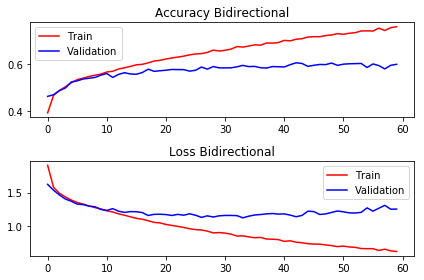

In [27]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy Bidirectional")
plt.plot(hist_acc_bi, color="r", label="Train")
plt.plot(hist_val_acc_bi, color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss Bidirectional")
plt.plot(hist_loss_bi, color="r", label="Train")
plt.plot(hist_val_loss_bi, color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()